In [20]:
# !pip install pandarallel
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install scikit-learn
# !pip install openpyxl
# !pip install imblearn
# !pip install -U xgboost

# Model Experimentation Notebook

## High-level problem statement
E-commerce websites often transact huge amounts of money. Whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, laundering money, etc. 

## Objective
The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

## Imports

In [42]:
import pandas as pd
import numpy as np
from pandarallel import pandarallel
pandarallel.initialize()

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

import joblib

import warnings
warnings.filterwarnings('ignore')


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## 1. Read Data

#### 1.1 Read Transaction data

In [22]:
def read_transaction_data(filename = "Candidate_tech_evaluation_candidate_copy_data science_fraud.csv"):
    '''
    input parameters:
        filename: filename of the transaction data file
    return:
        df_ip_country: dataframe with the transaction records
    '''
    # read transaction file data
    df_transactions = pd.read_csv(filename,
                                  usecols = ["user_id","signup_time","purchase_time","purchase_value","device_id",
                                             "source","browser","sex","age","ip_address","class"])
    
    # convert signup_time, purchase_time into datetime objects
    df_transactions["signup_time"] = pd.to_datetime(df_transactions["signup_time"])
    df_transactions["purchase_time"] = pd.to_datetime(df_transactions["purchase_time"])
    
    return df_transactions

#### 1.2 Read IP address and country data

In [23]:
def read_ip_data(filename = "Candidate_tech_evaluation_candidate_copy_datascience_IpAddress_to_Country.xlsx"):
    '''
    input parameters:
        filename: filename of the ip address and country file
    return:
        df_ip_country: dataframe with the ip addresses and country details
    '''
    
    # read transaction file data
    df_ip_country = pd.read_excel(filename)
    
    # convert signup_time, purchase_time into datetime objects
    df_transactions["signup_time"] = pd.to_datetime(df_transactions["signup_time"])
    df_transactions["purchase_time"] = pd.to_datetime(df_transactions["purchase_time"])
    
    return df_ip_country

#### 1.3 Join both dataframes

- As the two data frames are huge and doing a join will take some time
- Used pandas parallel apply to parallelize the join
- There are few ip addresses which doesnot match with the ip addresses in the ip-country file
- Assigned "UNK" - unknown as country for records for which we didnot find a country value in ip-country file
- There are about "17418" such "UNK" records

In [24]:
def custom_join(transaction_ip, df_ip_country):
    '''
    input parameters:
        transaction_ip: single referebce ip address
        df_ip_country: dataframe with the ip addresses and country details
    return:
        country_list[0]: country name of the input ip address
    '''
    country_list = df_ip_country[(df_ip_country["lower_bound_ip_address"]<=transaction_ip) &
                                 (df_ip_country["upper_bound_ip_address"]>=transaction_ip)]["country"].values
    if len(country_list) == 0:
        return "UNK"
    else:
        return  country_list[0]

## 2. Feature Engineering

#### Additional Feature 1.
Time difference between the signup and purchase time

In [25]:
def add_time_diff(df_transactions, return_frame=True):
    s = (df_transactions["signup_time"]-df_transactions["purchase_time"]).dt.seconds
    if return_frame:
        return s.to_frame()
    return s

ft_time_diff = FunctionTransformer(add_time_diff)

#### Additional Feature 2.
How many times same device is being used by different users

In [26]:
def add_device_count(df_transactions, return_frame=True):
    s = df_transactions.groupby("device_id")["user_id"].transform("count")
    if return_frame:
        return s.to_frame()
    return s

ft_device_count = FunctionTransformer(add_device_count)

#### Additonal Feature 3.
- Number of different ip address used by same user-id

In [27]:
def add_multiple_ips(df_transactions, return_frame=True):
    s = df_transactions.groupby("ip_address")["user_id"].transform("count")
    if return_frame:
        return s.to_frame()
    return s

ft_multiple_ips = FunctionTransformer(add_multiple_ips)

#### Additonal Feature 4.
- Signup time: day

In [28]:
def add_signup_day(df_transactions, return_frame=True):
    s = df_transactions['signup_time'].apply(lambda x: x.weekday())
    if return_frame:
        return s.to_frame()
    return s

ft_signup_day = FunctionTransformer(add_signup_day)

#### Additonal Feature 5.
- Signup time: week number

In [29]:
def add_signup_week(df_transactions, return_frame=True):
    s = df_transactions['signup_time'].apply(lambda x: x.week)
    if return_frame:
        return s.to_frame()
    return s

ft_signup_week = FunctionTransformer(add_signup_week)

#### Additonal Feature 6.
- Purchase time: day

In [30]:
def add_purchase_day(df_transactions, return_frame=True):
    s = df_transactions['purchase_time'].apply(lambda x: x.weekday())
    if return_frame:
        return s.to_frame()
    return s

ft_purchase_day = FunctionTransformer(add_purchase_day)

#### Additonal Feature 7.
- Purchase time: week number

In [31]:
def add_purchase_week(df_transactions, return_frame=True):
    s = df_transactions['purchase_time'].apply(lambda x: x.week)
    if return_frame:
        return s.to_frame()
    return s

ft_purchase_week = FunctionTransformer(add_purchase_week)

#### 2.1 Feature extraction pipeline
 - Additional features and one-hot encoding of the categorical features

In [32]:
cat_features = ["source","browser","sex","country"]

feature_engineering_pipeline = ColumnTransformer([
    ('time_diff', ft_time_diff, ['signup_time', 'purchase_time']),
    ('device_count', ft_device_count, ["device_id","user_id"]),
    ('multiple_ips', ft_multiple_ips, ["ip_address","user_id"] ),
    ('signup_day', ft_signup_day, ['signup_time']),
    ('signup_week', ft_signup_week,['signup_time']),
    ('purchase_day', ft_purchase_day,['purchase_time']),
    ('purchase_week', ft_purchase_week, ['purchase_time']),
    ("cat", OneHotEncoder(handle_unknown = "ignore", sparse = False), cat_features)
    ], remainder='passthrough')



## 3. Helper Functions

#### 3.1 Evaluation metrics function

In [33]:
def compute_metrics(X_test, y_test, clf):
    '''
    function which computes metrics precision, recall, f1 and also plots the confusion matrix, 
    precision-recall & roc curve
    
    inputs:
        X_test : input features
        y_test : target labels
        clf: model
    '''
    
    # test predictions 
    y_pred = clf.predict(X_test)
    
    # presicion, recall and f1 scores
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    print('Recall={0:0.3f},'.format(recall),'Precision={0:0.3f},'.format(precision),'F1={0:0.3f}'.format(F1))
    
    # set figure
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))
    
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix')
    
    # presicion - recall curve
    precisions, recalls, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:,1])
    axes[1].plot(recalls, precisions, "b-", linewidth=2)
    axes[1].plot(recalls, precisions, marker='.', label='Logistic')
    axes[1].set_xlabel("Recall", fontsize=16)
    axes[1].set_ylabel("Precision", fontsize=16)
    axes[1].axis([0, 1, 0, 1])
    axes[1].grid(True)
    axes[1].set_title('Precision - Recall Curve')

    # roc curve
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    axes[2].plot(fpr, tpr, label='(area = %0.2f)' % roc_auc)
    axes[2].plot([0, 1], [0, 1],'r--')
    axes[2].set_xlim([-0.05, 1.05])
    axes[2].set_ylim([-0.05, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title('Receiver operating characteristic')
    axes[2].legend(loc="lower right")

    return
    

#### 3.2 Cost calculation function
- Over all cost is calculated as "the total average cost per transactions considering all the transacations in train/test"
- As the train or test datasets sizes vary, it is good to calcualte average cost per transaction
- Lower the avergae cost per transaction better the model

In [34]:
def custom_loss_func(clf, X_test, y_test):
    '''
    function which calculates the over all cost ($8 for flase positive and product value for  flase negatives)
    inputs:
        X_test : input features
        y_test : target labels
        clf: model
    ouput:
        cost
    '''
    
    y = y_test.values
    y_pred = clf.predict(X_test)
    X_purchase = X_test["purchase_value"].values
    sum = 0
    for i in range(len(y)):
        if y[i] == 0 and y_pred[i] == 1:
            sum += 8
        elif y[i] == 1 and y_pred[i] == 0:
            sum += X_purchase[i]
    return sum/X_test.shape[0]

#### 3.3 Save model

In [35]:
def save_model(model,filename):
    '''save models in the specified path'''
    joblib.dump(model, filename)
    return

#### 3.4 Load a model

In [36]:
def load_model(model,filename):
    '''load models in the specified path'''
    return joblib.load(filename)

#### 3.5 Predictions

In [37]:
def predictions(clf, X):
    return clf.predict(X)

## 4. Prepare the data for ML model 
- Step 1: Read transaction data
- Step 2: Read ip addresses and country data
- Step 3: join both the dataframes
- Step 4: split joined data into train and test

In [38]:
# Read data from files and join
df_transactions = read_transaction_data()
df_ip_country = read_ip_data()
df_transactions["country"] = df_transactions["ip_address"].parallel_apply(lambda x:custom_join(x,df_ip_country))
df_transactions = df_transactions[['user_id', 'signup_time', 'purchase_time',
                                   'device_id', 'source', 'browser', 'sex', 'age', 'ip_address',
                                   'country', 'purchase_value', 'class']]

## Split the data into train and test set
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df_transactions, df_transactions["class"]):
    train_set = df_transactions.loc[train_index]
    test_set = df_transactions.loc[test_index]

X_train = train_set.drop(['class'], axis=1)
y_train = train_set["class"].copy()

X_test = test_set.drop(['class'], axis=1)
y_test = test_set["class"].copy()


## 5. Training classification models

As the data is highly unbalanced data, i have tried incorporating three high level techniques:
1. Class weighting techniques like XGBoost with scale_pos_weight
2. sampling + ML classifiers like BalancedRandomForestClassifier, RUSBoostClassifier
3. Shallow NN like MLP

- All these models are nonlinear classifiers as this input dataset is not a linearly separable
- Used Grid search with cross validation to tune few hyper parameters
- For each model (Train and test) plotted confusion matrix, presicion and recall curves and roc curves.

#### 5.1 XGBoost model with class weight adjustment (scale_pos_weight)
- XGBoost can handle the imbalance dataset with the "scale_pos_weight"
- "scale_pos_weight" is normally set to fraction of minority class
- Gridsearch on few parameters resulted in below model configuration,
{'model__max_depth': 10, 'model__n_estimators': 100, 'model__scale_pos_weight': 0.103}
-  Average Cost per transaction on test dataset: $ 1.89

In [50]:
from xgboost import XGBClassifier

fraud_ratio = y_train.value_counts()[1]/y_train.value_counts()[0]

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('feature_engineering_pipeline', feature_engineering_pipeline),
    ('model', XGBClassifier(random_state = 42, n_jobs = -1))
])

# hyperparameters to tune
param_grid = {
            'model__max_depth': [6,10], 
            'model__n_estimators': [100], 
            'model__scale_pos_weight': [1, fraud_ratio]
}

# grid search 
xgb_gcv = GridSearchCV(pipe, 
                       param_grid = param_grid,
                       scoring = "f1", 
                       cv = 5, 
                       n_jobs = -1)

# model fit
xgb_gcv.fit(X_train, y_train)
print("\nBest model", xgb_gcv.best_params_)

# save the  model
save_model(xgb_gcv.best_estimator_,"xgb_gcv.pkl")

# load the model
xgb_gcv = joblib.load("xgb_gcv.pkl")

Recall=0.537, Precision=1.000, F1=0.699

 Average Cost per transaction assocaited with the best model: $ 1.62


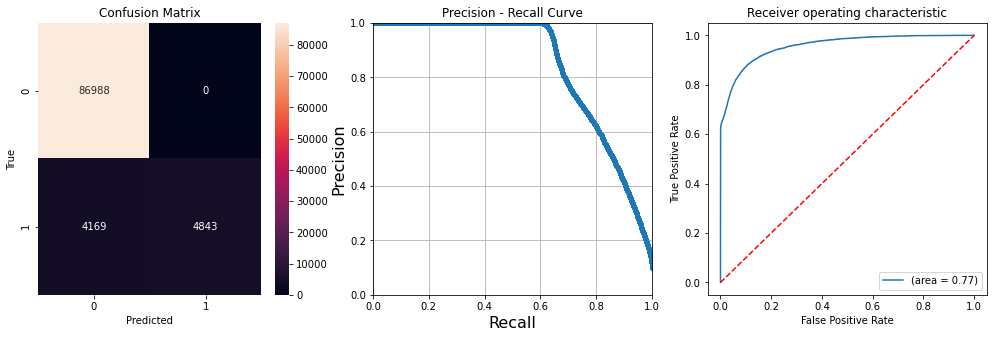

In [43]:
# Training metrics
compute_metrics(X_train, y_train, xgb_gcv)
print("\n Average Cost per transaction assocaited with the best model: $", round(custom_loss_func(xgb_gcv, X_train, y_train),2))


Recall=0.451, Precision=1.000, F1=0.621

 Average Cost per transaction assocaited with the best model: $ 1.89


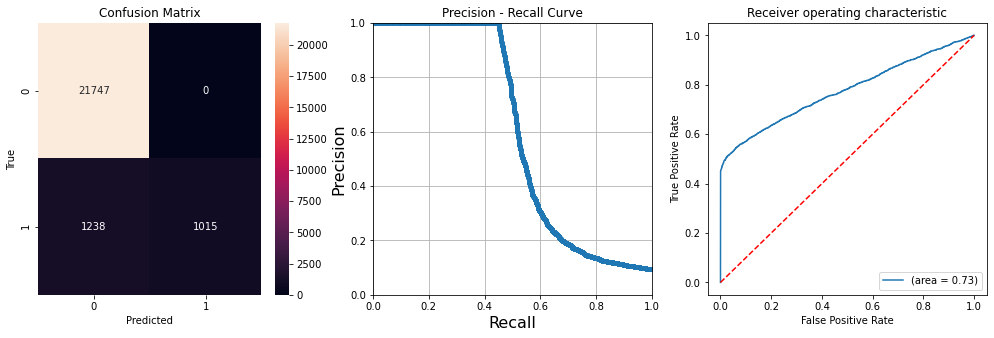

In [44]:
# Testing metrics
compute_metrics(X_test, y_test, xgb_gcv)
print("\n Average Cost per transaction assocaited with the best model: $", round(custom_loss_func(xgb_gcv, X_test, y_test),2))


#### 5.2 Random forest classifier model with balancing 
- A balanced random forest randomly under-samples each boostrap sample to balance it.
- Gridsearch on few parameters resulted in below model configuration,
{'model__max_depth': 6, 'model__n_estimators': 200}
-  Average Cost per transaction on test dataset: $ 1.56

In [51]:
from imblearn.ensemble import BalancedRandomForestClassifier

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('feature_engineering_pipeline', feature_engineering_pipeline),
    ('model', BalancedRandomForestClassifier(random_state = 42, n_jobs = -1))
])

# hyperparameters to tune
param_grid = {
            'model__max_depth': [6,10], 
            'model__n_estimators': [100,200]
}


# grid search 
rf_gcv = GridSearchCV(pipe, 
                       param_grid = param_grid,
                       scoring = "f1", 
                       cv = 5, 
                       n_jobs = -1)

rf_gcv.fit(X_train, y_train)
print("\nBest model", rf_gcv.best_params_)

# save the  model
save_model(rf_gcv.best_estimator_,"rf_gcv.pkl")

# load the model
rf_gcv = joblib.load("rf_gcv.pkl")

Recall=0.643, Precision=0.626, F1=0.635

Total Cost assocaited with the best model[TRAIN]: 1.5241354166666667


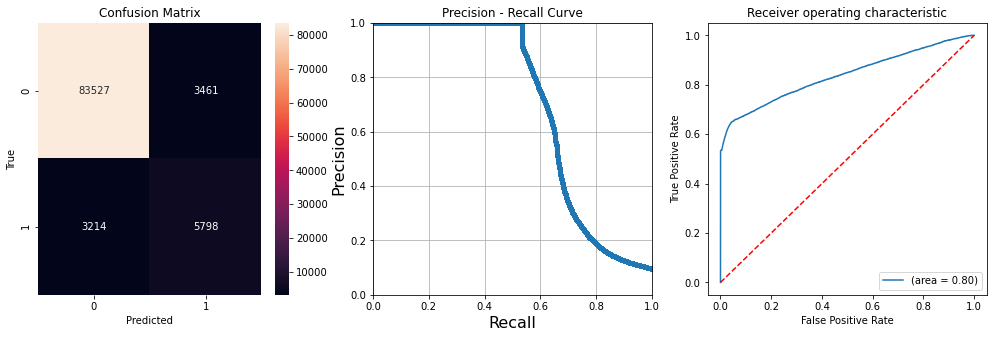

In [52]:
# Train metrics
compute_metrics(X_train, y_train, rf_gcv)
print("\nTotal Cost assocaited with the best model[TRAIN]:", custom_loss_func(rf_gcv, X_train, y_train))

Recall=0.572, Precision=0.815, F1=0.672

Total Cost assocaited with the best model: 1.566


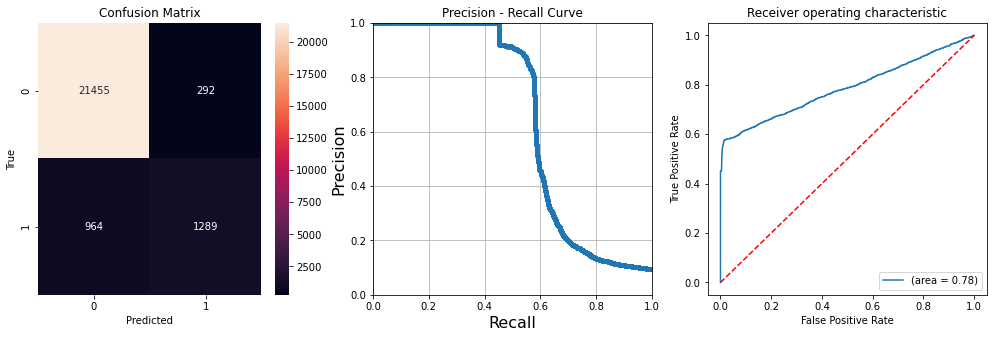

In [53]:
# Test metrics
compute_metrics(X_test, y_test, rf_gcv)
print("\nTotal Cost assocaited with the best model:", custom_loss_func(rf_gcv, X_test, y_test))

#### 5.3 Random under sampling with Adaboost

- Random under-sampling integrated in the learning of AdaBoost.
- Gridsearch on few parameters resulted in below model configuration,
{'model__n_estimators': 100}
-  Average Cost per transaction on test dataset: $ 1.58

In [57]:
from imblearn.ensemble import RUSBoostClassifier

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('feature_engineering_pipeline', feature_engineering_pipeline),
    ('model', RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
                              random_state=0))
])

# hyperparameters to tune
param_grid = { 
            'model__n_estimators': [100,200,300]
}


# grid search 
ru_gcv = GridSearchCV(pipe, 
                       param_grid = param_grid,
                       scoring = "f1", 
                       cv = 5, 
                       n_jobs = -1)

ru_gcv.fit(X_train, y_train)
print("\nBest model", ru_gcv.best_params_)

# save the  model
save_model(ru_gcv.best_estimator_,"ru_gcv.pkl")
# # load the  model
ru_gcv = joblib.load("ru_gcv.pkl")

Recall=0.650, Precision=0.591, F1=0.619

Total Cost assocaited with the best model: 1.5548958333333334


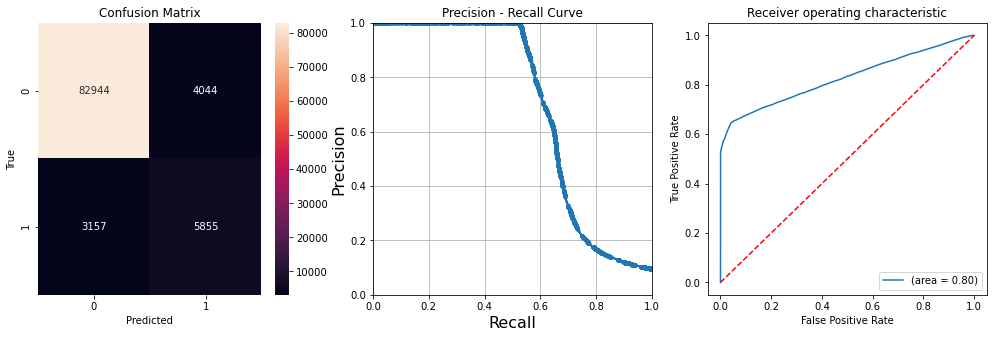

In [58]:
# Train metrics
compute_metrics(X_train, y_train, ru_gcv)
print("\nTotal Cost assocaited with the best model:", custom_loss_func(ru_gcv, X_train, y_train))

Recall=0.578, Precision=0.767, F1=0.659

Total Cost assocaited with the best model: 1.5839583333333334


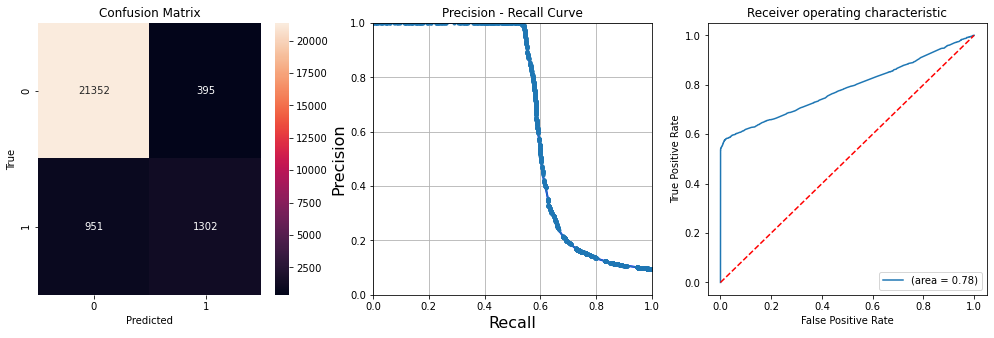

In [59]:
# Test metrics
compute_metrics(X_test, y_test, ru_gcv)
print("\nTotal Cost assocaited with the best model:", custom_loss_func(ru_gcv, X_test, y_test))

#### 5.4 Multi Layer Perceptron - Basic Neural Networks

- Simple Neural network to classify the fraud transacations
- Gridsearch on few parameters resulted in below model configuration,
{'model__alpha': 0.05, 'model__hidden_layer_sizes': (100, 30), 'model__learning_rate': 'constant'}
-  Average Cost per transaction on test dataset: $ 1.59

In [60]:
from sklearn.neural_network import MLPClassifier

# Fit a pipeline with transformers and an estimator to the training data
pipe = Pipeline([
    ('feature_engineering_pipeline', feature_engineering_pipeline),
    ('model', MLPClassifier(max_iter=100))
])

# hyperparameters to tune
param_grid = { 
    'model__hidden_layer_sizes': [(100,30),(100,30,10)],
    'model__alpha': [0.0001, 0.05],
    'model__learning_rate': ['constant','adaptive'],
}


# grid search 
mlp_gcv = GridSearchCV(pipe, 
                       param_grid = param_grid,
                       scoring = "f1", 
                       cv = 5, 
                       n_jobs = -1)

mlp_gcv.fit(X_train, y_train)
print("\nBest model", mlp_gcv.best_params_)

# save the model
save_model(mlp_gcv.best_estimator_,"mlp_gcv.pkl")
# load the  model
mlp_gcv = joblib.load("mlp_gcv.pkl")

Recall=0.525, Precision=1.000, F1=0.689

Total Cost assocaited with the best model: 1.6696875


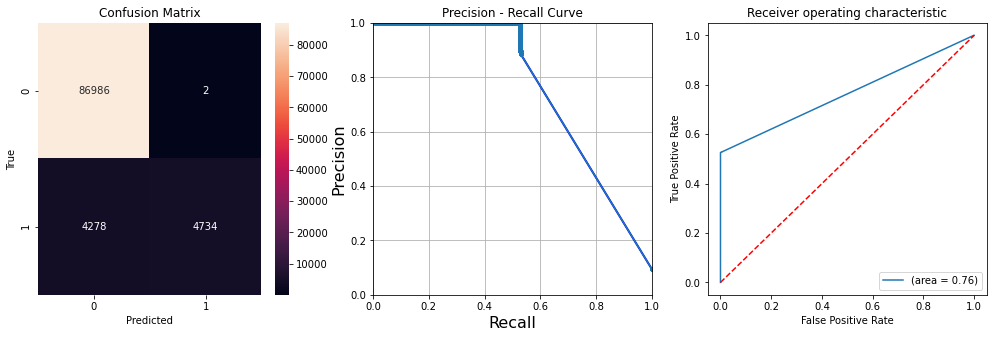

In [61]:
# Train metrics
compute_metrics(X_train, y_train, mlp_gcv)
print("\nTotal Cost assocaited with the best model:", custom_loss_func(mlp_gcv, X_train, y_train))

Recall=0.534, Precision=1.000, F1=0.696

Total Cost assocaited with the best model: 1.591625


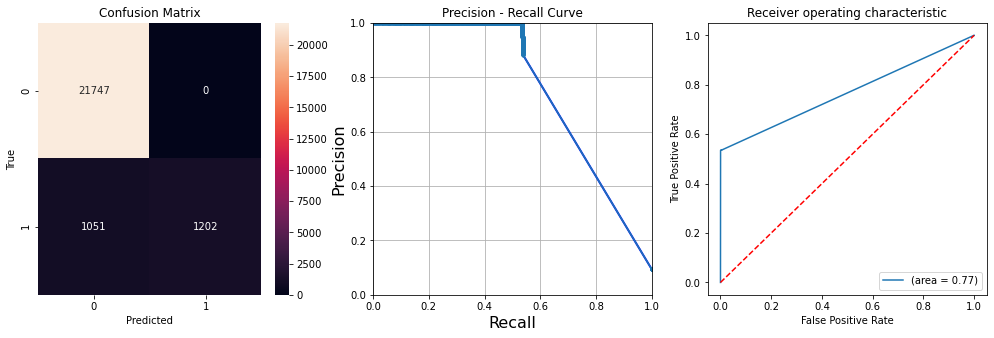

In [62]:
# Test metrics
compute_metrics(X_test, y_test, mlp_gcv)
print("\nTotal Cost assocaited with the best model:", custom_loss_func(mlp_gcv, X_test, y_test))

## Summary:

|Model|Recall|Presicion|F1|Average cost per transaction|
|---|---|---|---|--|
| XGBClassifier | 0.451 | 1.000 | 0.621 | 1.89 |
| BalancedRandomForestClassifier | 0.572 | 0.815 | 0.672 | 1.56 |
| RUSBoostClassifier | 0.578 | 0.767 | 0.659 | 1.58 |
| MLPClassifier | 0.534 | 1.000 | 0.696 | 1.59 |


- Out of all the models BalancedRandomForestClassifier is slightly doing better with 1.56 average cost per transaction and 0.67 f1score, we can consider this model for further improvements
- RUSBoostClassifier and MLPClassifier are also equaly better models with 1.58 and 1.59 avergae cost
- Models tried so far considered only few parameters and fine tuning is not done on a large scale
- Futher model fine tunning of the models is required by considering larger set of hyper parameters and thier ranges
- custom cost/scoring functions can be used in grid search to get the optimal probability thresholds using precision-recall curves (e.g. scoring fucntion sum( FP=>8 || FN=>product value)
- There are few clear patterns like if time difference between the signup and purchase time is small thier is high chance of fraudulent transaction
- As next step we can use random forest model to plot feature importance to see which feature is influence the model alot

Note: 
- use predictions(clf, X) function get the predictions
- for metrics (precision, recall, f1, confusion matrix ) using compute_metrics(X, y, clf)

